<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Bond-Prices" data-toc-modified-id="Bond-Prices-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Bond Prices</a></span></li><li><span><a href="#Model-Setup" data-toc-modified-id="Model-Setup-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Model Setup</a></span><ul class="toc-item"><li><span><a href="#Nelson-Siegel" data-toc-modified-id="Nelson-Siegel-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Nelson Siegel</a></span></li></ul></li><li><span><a href="#Minimization" data-toc-modified-id="Minimization-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Minimization</a></span></li><li><span><a href="#The-Spot-Rate-Curve" data-toc-modified-id="The-Spot-Rate-Curve-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>The Spot Rate Curve</a></span></li><li><span><a href="#Model-Prices-and-Residuals" data-toc-modified-id="Model-Prices-and-Residuals-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Model Prices and Residuals</a></span></li><li><span><a href="#Computing-the-Spot-Curve-for-all-historical-dates" data-toc-modified-id="Computing-the-Spot-Curve-for-all-historical-dates-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Computing the Spot Curve for all historical dates</a></span></li><li><span><a href="#Term-Structure-Evolution" data-toc-modified-id="Term-Structure-Evolution-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Term Structure Evolution</a></span></li><li><span><a href="#Principal-Component-Analysis" data-toc-modified-id="Principal-Component-Analysis-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Principal Component Analysis</a></span><ul class="toc-item"><li><span><a href="#Explained-Variance" data-toc-modified-id="Explained-Variance-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>Explained Variance</a></span></li><li><span><a href="#Principal-Components-Perturbations" data-toc-modified-id="Principal-Components-Perturbations-8.2"><span class="toc-item-num">8.2&nbsp;&nbsp;</span>Principal Components Perturbations</a></span></li><li><span><a href="#Principal-Components-Dollar-Durations" data-toc-modified-id="Principal-Components-Dollar-Durations-8.3"><span class="toc-item-num">8.3&nbsp;&nbsp;</span>Principal Components Dollar Durations</a></span></li></ul></li><li><span><a href="#Hedging" data-toc-modified-id="Hedging-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Hedging</a></span><ul class="toc-item"><li><span><a href="#Original-Portfolio" data-toc-modified-id="Original-Portfolio-9.1"><span class="toc-item-num">9.1&nbsp;&nbsp;</span>Original Portfolio</a></span></li><li><span><a href="#Duration-Hedge" data-toc-modified-id="Duration-Hedge-9.2"><span class="toc-item-num">9.2&nbsp;&nbsp;</span>Duration Hedge</a></span></li><li><span><a href="#PCA-Hedge" data-toc-modified-id="PCA-Hedge-9.3"><span class="toc-item-num">9.3&nbsp;&nbsp;</span>PCA Hedge</a></span></li><li><span><a href="#Comparative" data-toc-modified-id="Comparative-9.4"><span class="toc-item-num">9.4&nbsp;&nbsp;</span>Comparative</a></span></li></ul></li></ul></div>

This notebook follows from another notebook "Spot Rate Curve Fitting" and continues to explore PCA hedging

# Principal Component Hedging

In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import datetime as dt
import QuantLib as ql
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from prettytable import PrettyTable
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from sklearn.decomposition import PCA


from MachineTrading.AlgoTradingApp.app_run import AppBond
from MachineTrading.Utils.date_utils import date_to_quantlib, daterange

In [2]:
warnings.filterwarnings("ignore")

## Bond Prices

In [3]:
BTP_ISINS = [x.split('.')[0] for x in os.listdir("../AlgoTradingApp/Data/BondInfo") if 'IT0' in x]

bonds = {x:AppBond(x) for x in BTP_ISINS}

In [4]:
delete_isins = []
for isin, x in bonds.items():
    if x.bond.years_to_maturity() >= 30: 
        delete_isins.append(isin)

In [5]:
for x in delete_isins:
    del bonds[x]

In [6]:
year = 2022
month = 3
day = 22

reference_date = dt.date(year, month, day)
reference_date_ql = ql.Date(day, month, year)

for isin, b in bonds.items():
    b.update_data(reference_date)

data = []
for isin, b in bonds.items():
    data.append((isin, b.bond.maturity_date, b.years_to_maturity , b.price, b.yld, b.coupon))
    
data = sorted(data, key=lambda x: x[1])
data = pd.DataFrame(data)
data.columns = ['Isin', 'MaturityDate','YearsToMaturity', 'Price', 'Yield', 'Coupon']

In [7]:
data

,Isin,MaturityDate,YearsToMaturity,Price,Yield,Coupon
0,IT0005441719,"April 14th, 2022",0.062971,100.042491,-0.00735,0.00
1,IT0005447187,"June 14th, 2022",0.229979,100.144738,-0.00641,0.00
2,IT0005482937,"August 31st, 2022",0.443532,100.248925,-0.00571,0.00
3,IT0005440679,"November 29th, 2022",0.689938,100.293460,-0.00429,0.00
4,IT0005486748,"March 14th, 2023",0.977413,100.435310,-0.00446,0.00
5,IT0005424251,"January 15th, 2024",1.817933,99.687123,0.00173,0.00
6,IT0005408502,"July 1st, 2025",3.277207,103.602717,0.00734,1.85
7,IT0005454241,"August 1st, 2026",4.361396,95.583117,0.01039,0.00
8,IT0005390874,"January 15th, 2027",4.818617,98.770748,0.01113,0.85
9,IT0005433690,"March 15th, 2028",5.982204,93.501309,0.01387,0.25


## Model Setup

### Nelson Siegel

In [8]:
def nelson_siegel_rate(T, tau, b0, b1, b2):
    x = T/tau
    r = b0 + (b1+b2) * (1-np.exp(-x))/x - b2*np.exp(-x)
    return r

def nelson_siegel_discount_factor(T, tau, b0, b1, b2):
    df = np.exp(-nelson_siegel_rate(T, tau, b0, b1, b2)*T)
    return df

def nelson_siegel_bond_price(b, tau, b0, b1, b2, eval_date):    
    if isinstance(eval_date, dt.date):
        eval_date = date_to_quantlib(eval_date)
        
    cashflows = b.bond.bond.cashflows()
    cf = [(x.date(), x.amount()/100, b.bond.pricingDayCounter.yearFraction(eval_date, x.date()))
          for x in cashflows]
    cf = [x for x in cf if x[2] > 0]

    coupons = np.array([x[1] for x in cf])
    terms = np.array([x[2] for x in cf])

    cpns = 100 * (coupons[:-1] * nelson_siegel_discount_factor(terms[:-1], tau, b0, b1, b2))
    face = 100 * (nelson_siegel_discount_factor(terms[-1], tau, b0, b1, b2))
    price = np.sum(cpns)+face
    return price

def nelson_siegel_price_error(b, tau, b0, b1, b2, eval_date):
    ns_price = nelson_siegel_bond_price(b, tau, b0, b1, b2, eval_date)
    price_error = (ns_price - b.price) ** 2
    return price_error

def nelson_siegel_curve_fit(bonds, eval_date, disp=False):
    
    def fitting_func(args):
        tau, b0, b1, b2 = args
        total_error = 0
        for isin, b in bonds.items():
            price_error = nelson_siegel_price_error(b, tau, b0, b1, b2, eval_date)
            total_error += price_error
        return np.sqrt(total_error)

    ns_minimization_result = minimize(fitting_func, 
                                      x0=np.array([1, 0, 0, 0]),
                                      bounds=[(0, None), (0, 5), (-5, 5), (-5, 5)],
#                                       constraints = ({'type': 'ineq', 'fun': lambda x: x[1] + x[2]}),
                                      tol=1e-8, 
                                      options={'disp': disp}
                                     )
    return ns_minimization_result

## Minimization 

In [9]:
ne_minimization_result = nelson_siegel_curve_fit(bonds, reference_date_ql, True)

## The Spot Rate Curve

In [10]:
params = ne_minimization_result['x']

estandard_maturities = np.linspace(0.5, 30, 60)

zero_coupon_spot_curve = nelson_siegel_rate(estandard_maturities, 
                                            params[0], params[1], params[2], params[3])

In [11]:
np.round(params, 4)

array([ 1.2439,  0.0291, -0.0338, -0.0352])

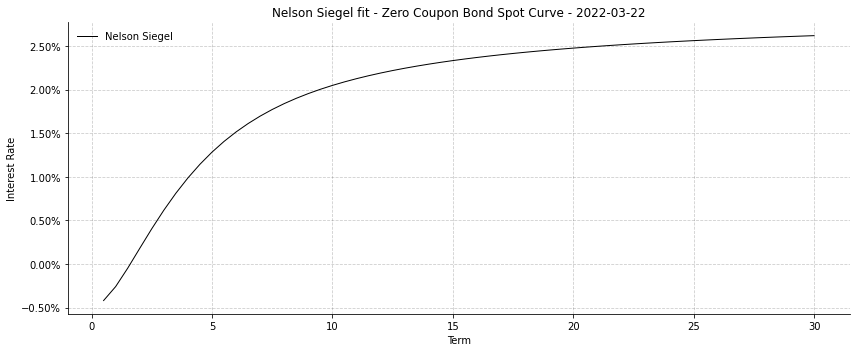

In [12]:
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(estandard_maturities, zero_coupon_spot_curve*100, color='k', lw=1, label='Nelson Siegel')

ax.legend(loc='best', frameon=False)
ax.set_xlabel("Term")
ax.set_ylabel("Interest Rate")
ax.set_title(f"Nelson Siegel fit - Zero Coupon Bond Spot Curve - {dt.date(2022,3,22)}")
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.grid(axis='both', alpha=0.2, color='k', ls='--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

## Model Prices and Residuals

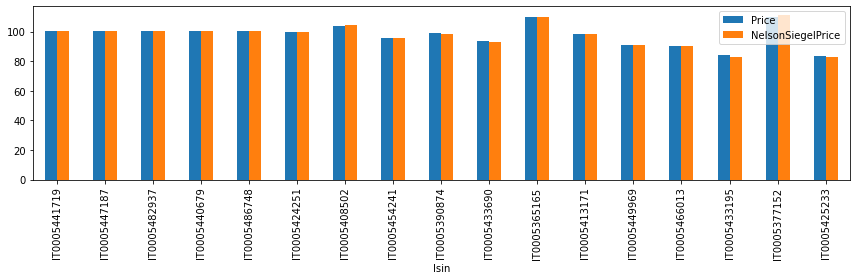

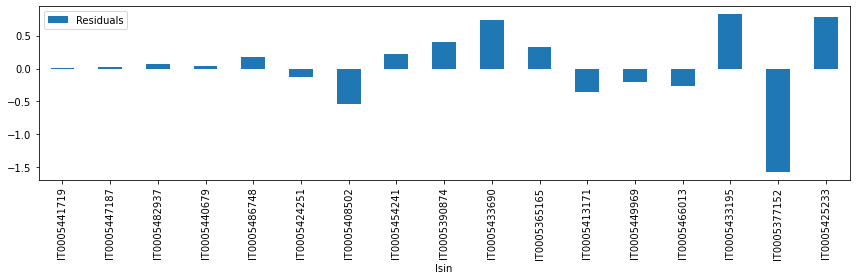

In [13]:
computed_prices = {}
for isin, b in bonds.items():
    computed_prices[isin] = nelson_siegel_bond_price(b, params[0], params[1], params[2], params[3], reference_date_ql)

data['NelsonSiegelPrice'] = data['Isin'].map(computed_prices)

data.set_index('Isin')[['Price', 'NelsonSiegelPrice']].plot(kind='bar', figsize=(12,4))
plt.tight_layout()
plt.show()

data['Residuals'] = data['Price']-data['NelsonSiegelPrice']

data.set_index('Isin')[['Residuals']].plot(kind='bar', figsize=(12,4))
plt.tight_layout()
plt.show()

## Computing the Spot Curve for all historical dates

In [14]:
curves = {}
fits = {}

date_range = daterange(dt.date(2021,9,1), dt.date(2022,3,23))
eval_dates = list(date_range)

for d in tqdm(eval_dates):
    
    ql_date = date_to_quantlib(d)
    for isin, b in bonds.items():
        b.update_data(d)

    res = nelson_siegel_curve_fit(bonds, ql_date, False)
    spot_curve = nelson_siegel_rate(estandard_maturities, res['x'][0], res['x'][1], res['x'][2], res['x'][3])
    
    curves[d] = spot_curve
    fits[d] = res['x']

  0%|          | 0/203 [00:00<?, ?it/s]

In [15]:
def logistic(x, k, x0=0.5):
    return 1 / (1+np.exp(-k*(x-x0)))

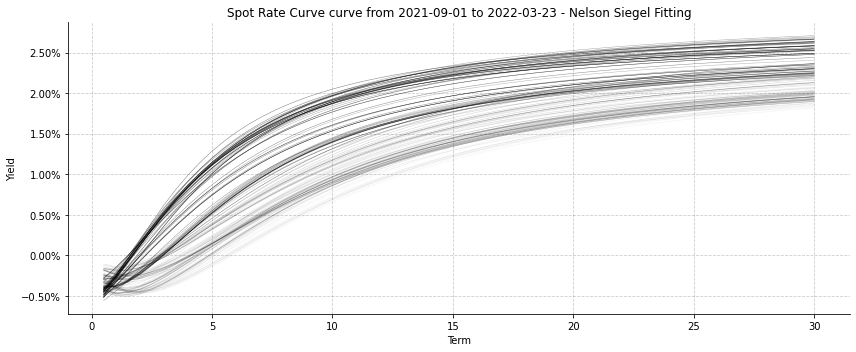

In [16]:
fig, ax = plt.subplots(figsize=(12,5))
for i, (d, cv) in enumerate(curves.items()):
    ax.plot(estandard_maturities, cv*100, color='k', alpha=logistic(i, 0.02, 200), lw=0.5)
    
ax.set_xlabel("Term")
ax.set_ylabel("Yield")
ax.set_title(f"Spot Rate Curve curve from {dt.date(2021,9,1)} to {dt.date(2022,3,23)} - Nelson Siegel Fitting")
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.grid(axis='both', alpha=0.2, color='k', ls='--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

## Term Structure Evolution

In [17]:
term_structure_evolution = pd.DataFrame.from_dict(curves).T
term_structure_evolution.columns = [str(x) for x in estandard_maturities]

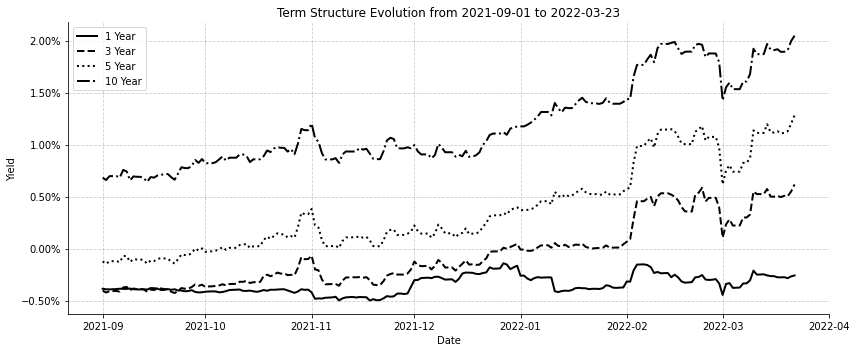

In [18]:
fig, ax = plt.subplots(figsize=(12,5))

lw = 2
ax.plot(term_structure_evolution.index, term_structure_evolution["1.0"]*100, color='k', lw=lw, label='1 Year')
ax.plot(term_structure_evolution.index, term_structure_evolution["3.0"]*100, color='k', ls='--', lw=lw, label='3 Year')
ax.plot(term_structure_evolution.index, term_structure_evolution["5.0"]*100, color='k', ls=':', lw=lw, label='5 Year')
ax.plot(term_structure_evolution.index, term_structure_evolution["10.0"]*100, color='k', ls='-.', lw=lw, label='10 Year')
    
ax.set_xlabel("Date")
ax.set_ylabel("Yield")
ax.set_title(f"Term Structure Evolution from {dt.date(2021,9,1)} to {dt.date(2022,3,23)}")
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.grid(axis='both', alpha=0.2, color='k', ls='--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend()
plt.tight_layout()
plt.show()

## Principal Component Analysis

In [19]:
NORMALIZE = False

if NORMALIZE:
    dfmean = term_structure_evolution.mean()
    dfstd = term_structure_evolution.std()
else:
    dfmean = term_structure_evolution.mean()*0
    dfstd = term_structure_evolution.std()/term_structure_evolution.std()

df = (term_structure_evolution-dfmean)/dfstd

pca = PCA(n_components=3)
pca.fit(df);

pca_components = pd.DataFrame(pca.components_.T, columns=['C1', 'C2', 'C3'])
pca_components.index = estandard_maturities

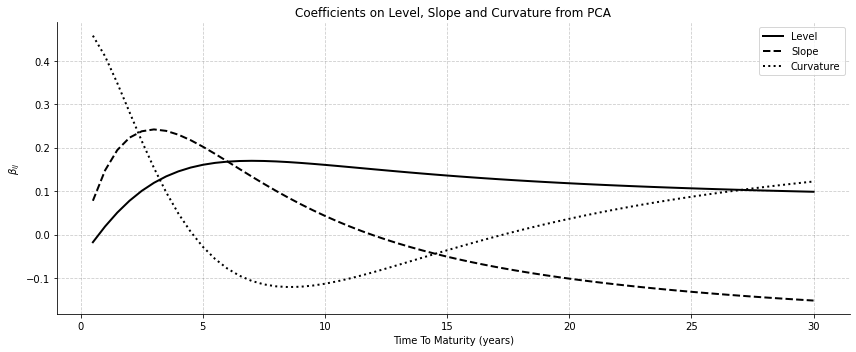

In [20]:
fig, ax = plt.subplots(figsize=(12,5))

ax.plot(pca_components['C1'], color='black', lw=2, ls='-', label='Level')
ax.plot(pca_components['C2'], color='black', lw=2, ls='--', label='Slope')
ax.plot(pca_components['C3'], color='black', lw=2, ls=':', label='Curvature')

ax.set_xlabel("Time To Maturity (years)")
ax.set_ylabel(r"$\beta_{ij}$")
ax.legend()
ax.grid(axis='both', alpha=0.2, color='k', ls='--')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_title("Coefficients on Level, Slope and Curvature from PCA")
plt.tight_layout()
plt.show()

In [21]:
transformed = pca.transform(df)

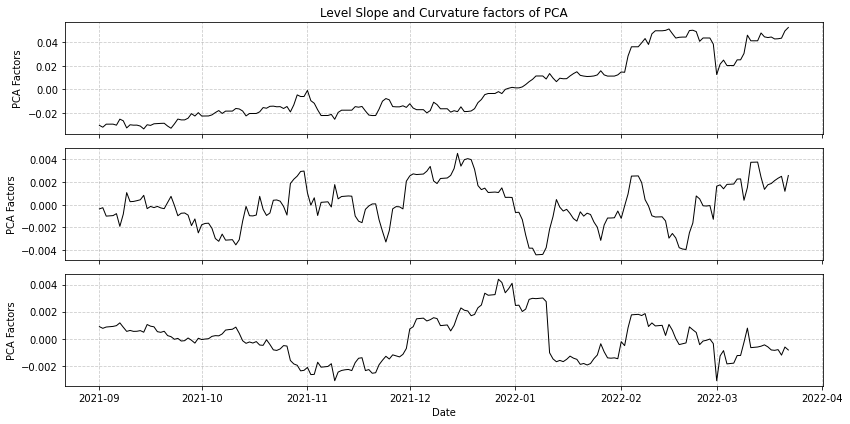

In [22]:
fig, axes = plt.subplots(figsize=(12,6), nrows=3, sharex=True)
axes[0].plot(sorted(list(curves.keys())), transformed.T[0], color='black', lw=1, ls='-', label='Level')
axes[1].plot(sorted(list(curves.keys())), transformed.T[1], color='black', lw=1, ls='-', label='Slope')
axes[2].plot(sorted(list(curves.keys())), transformed.T[2], color='black', lw=1, ls='-', label='Curvature')

axes[0].set_title("Level Slope and Curvature factors of PCA")

for ax in axes: 
#     ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    ax.grid(axis='both', alpha=0.2, color='k', ls='--')
    ax.set_ylabel("PCA Factors")

axes[2].set_xlabel("Date")

plt.tight_layout()
plt.show()

### Explained Variance

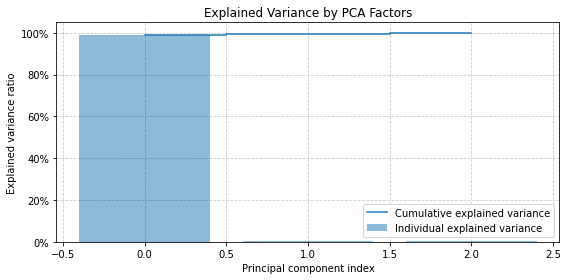

In [23]:
cum_sum_eigenvalues = np.cumsum(pca.explained_variance_ratio_*100)

fig, ax = plt.subplots(figsize=(8,4))

ax.bar(np.arange(3), pca.explained_variance_ratio_*100, alpha=0.5, align='center', label='Individual explained variance')
ax.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')

ax.set_title("Explained Variance by PCA Factors") 
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.grid(axis='both', alpha=0.2, color='k', ls='--')
ax.set_ylabel("PCA Factors")

ax.set_xlabel("Date")


ax.set_ylabel('Explained variance ratio')
ax.set_xlabel('Principal component index')

plt.legend(loc='best')
plt.tight_layout()
plt.show()


### Principal Components Perturbations

In [24]:
params_today = fits[dt.date(2022, 3, 21)]
params_tomorrow = fits[dt.date(2022, 3, 22)]

In [25]:
perturbation = 0.01

# LEVEL
t1 = transformed.copy()
t1[::,0] = t1[::,0]+perturbation
t1_inverse = pd.DataFrame(pca.inverse_transform(t1), columns=estandard_maturities)
t1_inverse = t1_inverse*dfstd.values+dfmean.values
params_level, pcov = curve_fit(nelson_siegel_rate, estandard_maturities, t1_inverse.iloc[-2].values)

# SLOPE
t2 = transformed.copy()
t2[::,1] = t2[::,1]+perturbation
t2_inverse = pd.DataFrame(pca.inverse_transform(t2), columns=estandard_maturities)
t2_inverse = t2_inverse*dfstd.values+dfmean.values
params_slope, pcov = curve_fit(nelson_siegel_rate, estandard_maturities, t2_inverse.iloc[-2].values)

# TWIST
t3 = transformed.copy()
t3[::,2] = t3[::,2]+perturbation
t3_inverse = pd.DataFrame(pca.inverse_transform(t3), columns=estandard_maturities)
t3_inverse = t3_inverse*dfstd.values+dfmean.values
params_twist, pcov = curve_fit(nelson_siegel_rate, estandard_maturities, t3_inverse.iloc[-2].values)

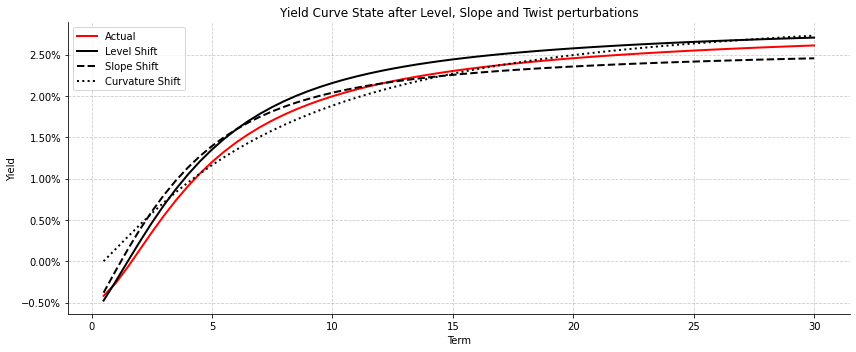

In [27]:
fig, ax = plt.subplots(figsize=(12,5))
idx = pd.Series(df.iloc[-1].index).astype(float)

df_back = df*dfstd.values+dfmean.values

ax.plot(idx, df_back.iloc[-2].values*100, color='red', lw=2, ls='-', label='Actual')
ax.plot(idx, t1_inverse.iloc[-2].values*100, color='k', lw=2, ls='-', label='Level Shift')
ax.plot(idx, t2_inverse.iloc[-2].values*100, color='k', lw=2, ls='--', label='Slope Shift')
ax.plot(idx, t3_inverse.iloc[-2].values*100, color='k', lw=2, ls=':', label='Curvature Shift')

ax.set_xlabel("Term")
ax.set_ylabel(r"Yield")
ax.legend()

ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.grid(axis='both', alpha=0.2, color='k', ls='--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_title("Yield Curve State after Level, Slope and Twist perturbations")

plt.tight_layout()
plt.show()

### Principal Components Dollar Durations

In [53]:
durations = {}
eval_date = dt.date(2022, 3, 21)
eval_date2 = dt.date(2022, 3, 22)

for isin, bond in bonds.items():
    bond.update_data(eval_date)
    term = bond.years_to_maturity
    
    actual_price = bond.price
    actual_yield = bond.yld
    
    current_price = nelson_siegel_bond_price(bond, params_today[0], params_today[1], params_today[2], params_today[3], eval_date)
    lvl_price = nelson_siegel_bond_price(bond, params_level[0], params_level[1], params_level[2], params_level[3], eval_date)
    slope_price = nelson_siegel_bond_price(bond, params_slope[0], params_slope[1], params_slope[2], params_slope[3], eval_date)
    twist_price = nelson_siegel_bond_price(bond, params_twist[0], params_twist[1], params_twist[2], params_twist[3], eval_date)
    
    current_yld = bond.bond.bond_yield(current_price, eval_date)
    lvl_yld = bond.bond.bond_yield(lvl_price, eval_date)
    slope_yld = bond.bond.bond_yield(slope_price, eval_date)
    twist_yld = bond.bond.bond_yield(twist_price, eval_date)
    
    tomorrow_prc = nelson_siegel_bond_price(bond, params_tomorrow[0], 
                                            params_tomorrow[1], params_tomorrow[2], 
                                            params_tomorrow[3], eval_date2)
    
    tomorrow_yld = bond.bond.bond_yield(tomorrow_prc, date_to_quantlib(eval_date2))
    
    level_duration = - (lvl_price-current_price) / np.abs(lvl_yld-current_yld) / 100
    slope_duration = - (slope_price-current_price) / np.abs(slope_yld-current_yld) /100
    twist_duration = - (twist_price-current_price) / np.abs(twist_yld-current_yld) / 100
    
    basis_point_move = (tomorrow_yld-current_yld)*10000
    
    dv01 = -bond.bond.bpv(current_price, eval_date=eval_date)*100
    duration = bond.bond.duration_modified(current_yld)
    
    durations[isin] = {'D1':level_duration, 
                       'D2':slope_duration, 
                       'D3':twist_duration,   
                       'Maturity':term, 
                       'DV01':dv01, 
                       'Duration':duration, 
                       'Price':current_price, 
                       'PriceLevel':lvl_price,
                       'PriceSlope':slope_price,
                       'PriceTwist':twist_price,
                       'Price2':tomorrow_prc, 
                       'Yield':current_yld, 
                       'Yield2':tomorrow_yld,
                       'YieldLevel':lvl_yld,
                       'YieldSlope':slope_yld,
                       'YieldTwist':twist_yld,
                       'ActualPrice':actual_price, 
                       'ActualYield':actual_yield,
                       'BPS':basis_point_move}

In [54]:
duration_df = pd.DataFrame.from_dict(durations).T.sort_values(by=['Maturity'])

duration_df['DollarDuration'] = duration_df['Duration']*duration_df['Price']/100

duration_df = duration_df.iloc[:-2].copy()

In [56]:
duration_df

,D1,D2,D3,Maturity,DV01,Duration,Price,PriceLevel,PriceSlope,PriceTwist,Price2,Yield,Yield2,YieldLevel,YieldSlope,YieldTwist,ActualPrice,ActualYield,BPS,DollarDuration
IT0005441719,-0.060684,-0.060673,0.060588,0.065708,0.066183,0.060641,100.040313,100.046931,100.042919,100.012507,100.039378,-0.006657,-0.006812,-0.007748,-0.007087,-0.002068,100.042937,-0.00709,-1.549969,0.060666
IT0005447187,-0.228932,0.228891,0.228533,0.232717,0.234395,0.228606,100.116821,100.133006,100.116073,100.023435,100.115710,-0.005114,-0.005127,-0.005821,-0.005081,-0.001027,100.147879,-0.00647,-0.131360,0.228874
IT0005482937,-0.439302,0.439156,0.438431,0.446270,0.444679,0.438413,100.182583,100.203009,100.167495,100.015915,100.182024,-0.004165,-0.004178,-0.004630,-0.003822,-0.000364,100.252682,-0.00576,-0.131826,0.439214
IT0005440679,-0.688136,0.687736,0.686395,0.692676,0.693617,0.686335,100.250524,100.266935,100.195377,99.970960,100.249353,-0.003649,-0.003647,-0.003887,-0.002847,0.000424,100.294649,-0.00429,0.023152,0.688055
IT0005486748,0.979452,0.978480,0.976408,0.980151,0.984958,0.976878,100.267085,100.259541,100.130520,99.850487,100.258671,-0.002732,-0.002654,-0.002655,-0.001337,0.001534,100.448313,-0.00458,0.785289,0.979487
IT0005424251,1.810435,1.807274,1.805028,1.820671,1.817552,1.814296,99.875882,99.736480,99.463401,99.269937,99.810114,0.000684,0.001049,0.001454,0.002967,0.004041,99.784322,0.00119,3.647054,1.812044
IT0005408502,3.319329,3.312146,3.319772,3.279945,3.333706,3.176076,104.370393,103.903337,103.520538,103.927442,104.135741,0.005032,0.005728,0.006440,0.007598,0.006367,103.836988,0.00664,6.955846,3.314883
IT0005454241,4.137425,4.130538,4.152686,4.364134,4.158806,4.340006,95.709231,95.032728,94.748952,95.664409,95.370062,0.010080,0.010905,0.011715,0.012404,0.010188,95.871202,0.00969,8.250672,4.153786
IT0005390874,4.621795,4.615996,-4.645539,4.821355,4.647336,4.693736,98.744723,97.969213,97.748993,98.866886,98.360699,0.011185,0.012016,0.012863,0.013342,0.010922,99.077068,0.01047,8.310306,4.634816
IT0005433690,5.462795,5.463286,-5.508901,5.984942,5.497203,5.892885,93.202212,92.275326,92.290160,93.709177,92.765424,0.014408,0.015211,0.016105,0.016078,0.013488,93.863016,0.01321,8.030150,5.492299


## Hedging

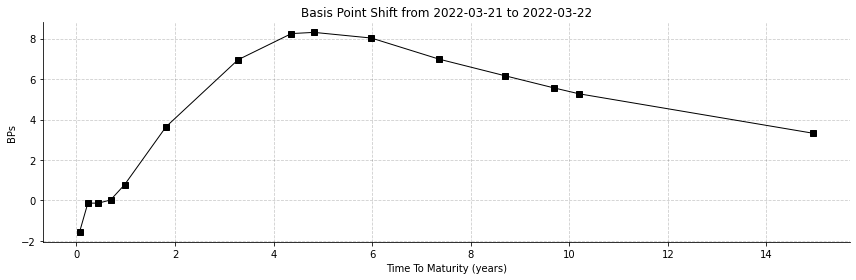

In [57]:
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(duration_df['Maturity'], duration_df['BPS'], 's-', color='k', lw=1)
ax.set_xlabel("Time To Maturity (years)")
ax.set_ylabel(r"BPs")

ax.grid(axis='both', alpha=0.2, color='k', ls='--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_title(f"Basis Point Shift from {eval_date} to {eval_date2}")

plt.tight_layout()
plt.show()

In [70]:
hedging_instruments = ['IT0005424251', 'IT0005413171', 'IT0005433195']

position = np.random.randint(-3,15, len(duration_df))*1E6

from matplotlib.ticker import FuncFormatter

def millions_formatter(x, pos):
    return f'{x * 1E-6}'

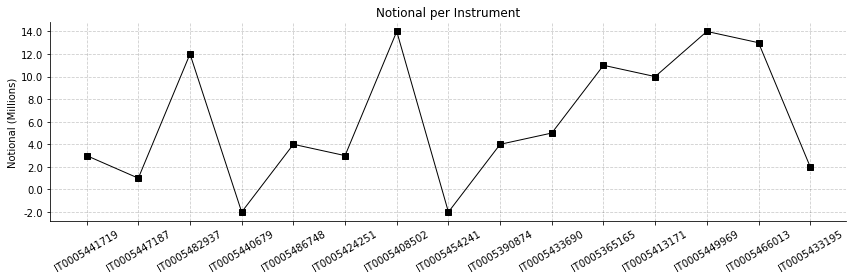

In [71]:
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(duration_df.index, position, 's-', color='k', lw=1)
ax.set_ylabel(r"Notional (Millions)")

ax.grid(axis='both', alpha=0.2, color='k', ls='--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.yaxis.set_major_formatter(FuncFormatter(millions_formatter))
ax.set_title(f"Notional per Instrument")
plt.xticks(rotation=30)

plt.tight_layout()
plt.show()

In [72]:
duration_df['Position'] = position

### Original Portfolio

In [73]:
# Original Portfolio Value
value1 = (duration_df['Position']*duration_df['Price']/100).sum()
value2 = (duration_df['Position']*duration_df['Price2']/100).sum()

pnl = value2-value1

print("Original Portfolio P&L:", f'{round(pnl,3):,}')

Original Portfolio P&L: -302,950.053


### Duration Hedge

In [74]:
duration_only_hedge = -(duration_df['DV01']*duration_df['Position']).sum()/5.518249

duration_df['DV01HedgeOnly'] = 0
duration_df.loc['IT0005433690', 'DV01HedgeOnly'] = duration_only_hedge

value1_d = ((duration_df['Position']+duration_df['DV01HedgeOnly'])*duration_df['Price']/100).sum()
value2_d = ((duration_df['Position']+duration_df['DV01HedgeOnly'])*duration_df['Price2']/100).sum()

pnl_duration_hedge = value2_d-value1_d

print("Duration Hedge Portfolio P&L:", f'{round(pnl_duration_hedge,3):,}')

Duration Hedge Portfolio P&L: 102,849.905


### PCA Hedge

In [75]:
a = np.array([[duration_df.loc[x]['D1'] for x in hedging_instruments], 
              [duration_df.loc[x]['D2'] for x in hedging_instruments], 
              [duration_df.loc[x]['D3'] for x in hedging_instruments]])

b = np.array([-(position*duration_df['D1'].values).sum(), 
              -(position*duration_df['D2'].values).sum(), 
              -(position*duration_df['D3'].values).sum()])

x = np.linalg.solve(a, b)

In [76]:
duration_df['Hedge'] = 0
for i, instrument in enumerate(hedging_instruments):
    duration_df.loc[instrument, 'Hedge'] = x[i]

duration_df['FullPortfolio'] = duration_df['Position']+duration_df['Hedge']

duration_df['Sensi'] = duration_df['DV01']*duration_df['FullPortfolio']/10000

duration_df['PortfolioSensi'] = duration_df['Position']*duration_df['DV01']/10000
duration_df['HedgeSensi'] = duration_df['Hedge']*duration_df['DV01']/10000

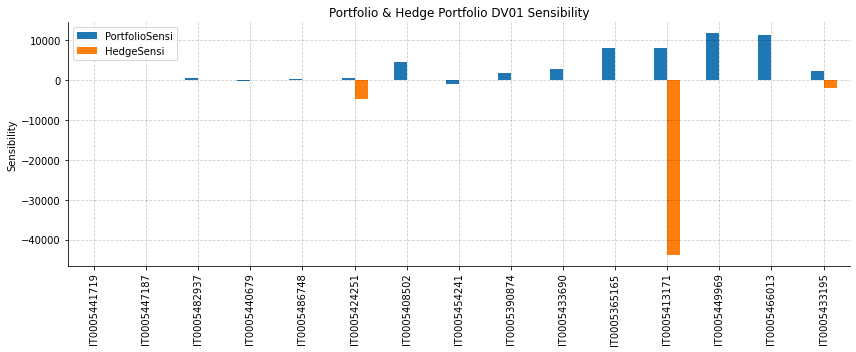

In [77]:
fig = duration_df[['PortfolioSensi', 'HedgeSensi']].plot(kind='bar', figsize=(12,5))
fig.axes.set_ylabel(r"Sensibility")
fig.axes.grid(axis='both', alpha=0.2, color='k', ls='--')
fig.axes.spines['top'].set_visible(False)
fig.axes.spines['right'].set_visible(False)
fig.axes.set_title("Portfolio & Hedge Portfolio DV01 Sensibility")
plt.tight_layout()
plt.show()

In [78]:
value1_h = (duration_df['FullPortfolio']*duration_df['Price']/100).sum()
value2_h = (duration_df['FullPortfolio']*duration_df['Price2']/100).sum()
pnl_pca_hedge = value2_h-value1_h

print("Duration Hedge Portfolio P&L:", f'{round(pnl_pca_hedge,3):,}')

Duration Hedge Portfolio P&L: -10,908.777


### Comparative

In [79]:
sensibility_original = (duration_df['DV01']*duration_df['Position']/10000).sum()
sensibility_pca_hedged = (duration_df['DV01']*duration_df['FullPortfolio']/10000).sum()
sensibility_duration_hedge = (duration_df['DV01']*(duration_df['Position']+duration_df['DV01HedgeOnly'])/10000).sum()

pf_d1_sensi = (duration_df['Position']*duration_df['D1']/10000).sum()
pf_d2_sensi = (duration_df['Position']*duration_df['D2']/10000).sum()
pf_d3_sensi = (duration_df['Position']*duration_df['D3']/10000).sum()

dur_d1_sensi = ((duration_df['Position']+duration_df['DV01HedgeOnly'])*duration_df['D1']/10000).sum()
dur_d2_sensi = ((duration_df['Position']+duration_df['DV01HedgeOnly'])*duration_df['D2']/10000).sum()
dur_d3_sensi = ((duration_df['Position']+duration_df['DV01HedgeOnly'])*duration_df['D3']/10000).sum()

pca_d1_sensi = (duration_df['FullPortfolio']*duration_df['D1']/10000).sum()
pca_d2_sensi = (duration_df['FullPortfolio']*duration_df['D2']/10000).sum()
pca_d3_sensi = (duration_df['FullPortfolio']*duration_df['D3']/10000).sum()

In [80]:
x = pd.DataFrame.from_records([["Original", pnl, sensibility_original, pf_d1_sensi, pf_d2_sensi, pf_d3_sensi], 
          ["Duration Hedge", pnl_duration_hedge, sensibility_duration_hedge, dur_d1_sensi, dur_d2_sensi, dur_d3_sensi], 
          ["PCA Hedge", pnl_pca_hedge, sensibility_pca_hedged, pca_d1_sensi, pca_d2_sensi, pca_d3_sensi]], 
                         columns=['Portfolio', 'P&L Variation', 'DV01', 'Level', 'Slope', 'Twist'])

In [81]:
x.set_index('Portfolio').round(2)

,P&L Variation,DV01,Level,Slope,Twist
Portfolio,,,,,
Original,-302950.05,51267.53,50029.72,46461.04,-41068.91
Duration Hedge,102849.91,195.53,-722.61,-4295.86,10111.77
PCA Hedge,-10908.78,875.76,-0.00,0.00,0.00
